# Example for analysis of NanoAOD samples

In this example we don't need any pre-processing of NanoAOD samples and can still use several tools of the tW_scattering repository.

- Get the proper normalization for samples
- Categorize different samples into process categories
- Use coffea processors for the map-reduce step
- Make "nice" histograms


In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.nano_analysis import nano_analysis
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

In [30]:
from klepto.archives import dir_archive
from processor.std_acumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

overwrite = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples()

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'TTZ', 'top'], samples, redirector=redirector_ucsd, small=False)

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
     "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        nano_analysis(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Preprocessing:   0%|          | 0/145 [00:00<?, ?file/s]

Processing:   0%|          | 0/726 [00:00<?, ?chunk/s]

In [31]:
output['totalEvents']['all']/1e6

178.034597

Full fileset is 180M events, and that's basically just DY and ttbar.

In [32]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', 20, 0, 400)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins       = hist.Bin('eta', r'$\eta $', 10, -2.5, 2.5)
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)


# define nicer labels and colors

my_labels = {
    nano_mapping['TTW'][0]: 'ttW',
    nano_mapping['TTZ'][0]: 'ttZ',
    nano_mapping['DY'][0]: 'DY',
    nano_mapping['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mapping['TTW'][0]: '#8AC926',
    nano_mapping['TTZ'][0]: '#FFCA3A',
    nano_mapping['DY'][0]: '#6A4C93',
    nano_mapping['top'][0]: '#1982C4',
}



Data: 0 MC: 10568472.25


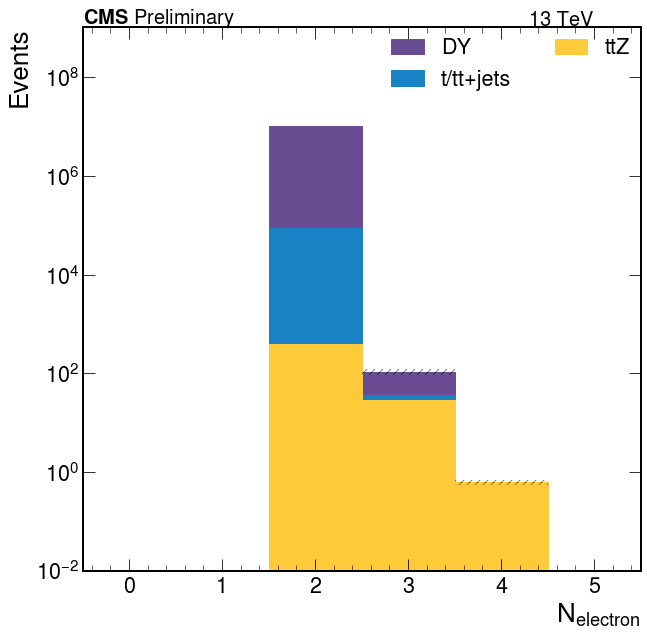

In [33]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping

my_hist = scale_and_merge(output['N_ele'], samples, fileset, nano_mapping)

# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 10568472.25


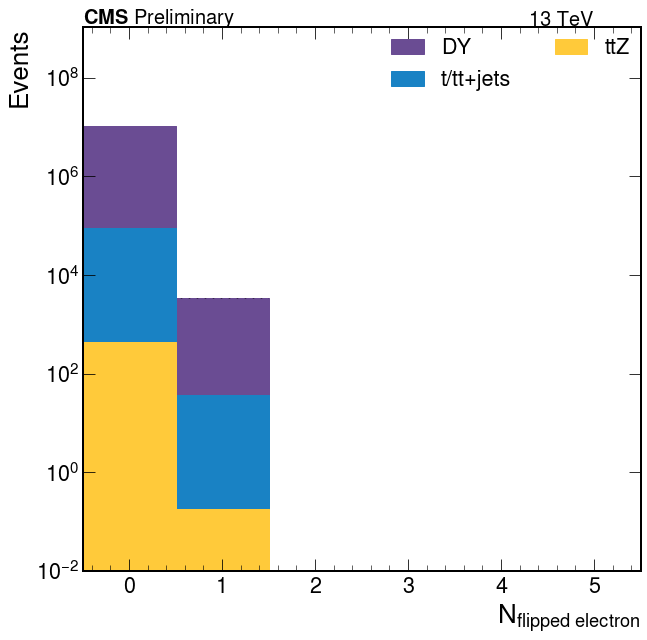

In [34]:
my_hist = scale_and_merge(output['electron_flips'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{flipped\ electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 10568472.25


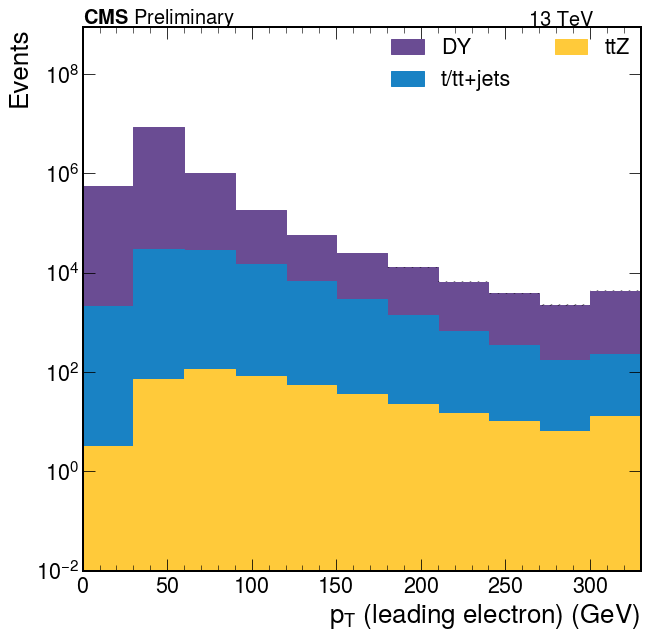

In [35]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (leading\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 3338.64


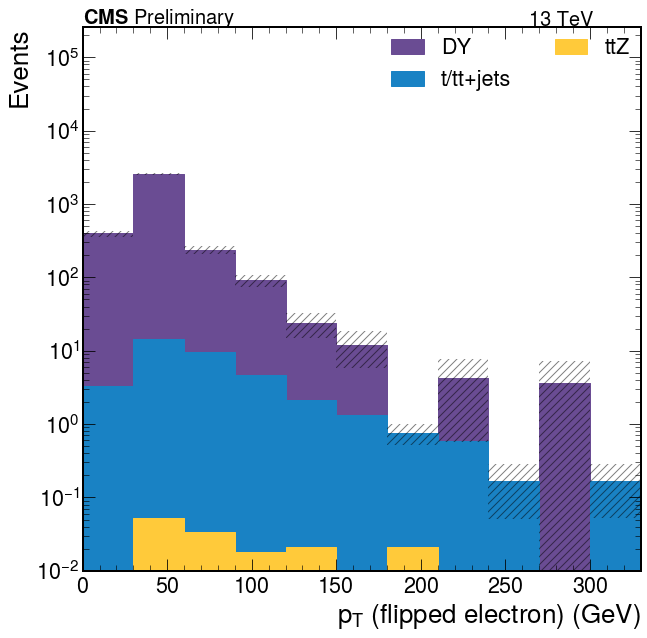

In [36]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (flipped\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 10568461.4


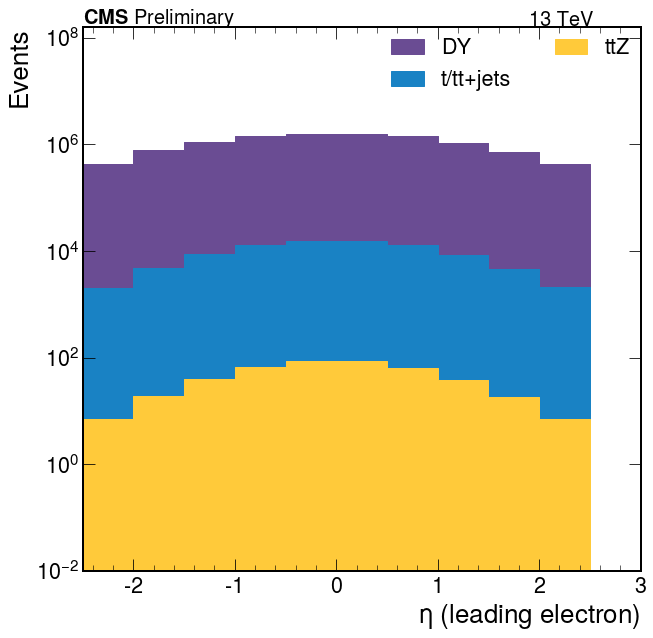

In [37]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (leading\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 3338.64


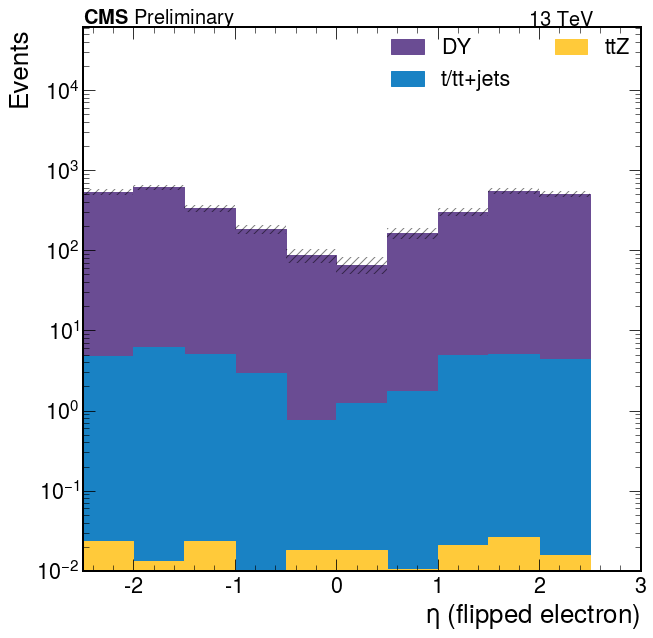

In [38]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (flipped\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

In [22]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'phi',
         bins=phi_bins, log=True, normalize=False, axis_label=r'$\phi\ (leading\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

KeyError: 'No axis phi found in <Hist (dataset,pt,eta) instance at 0x7f02a828eca0>'

Data: 0 MC: 510.4


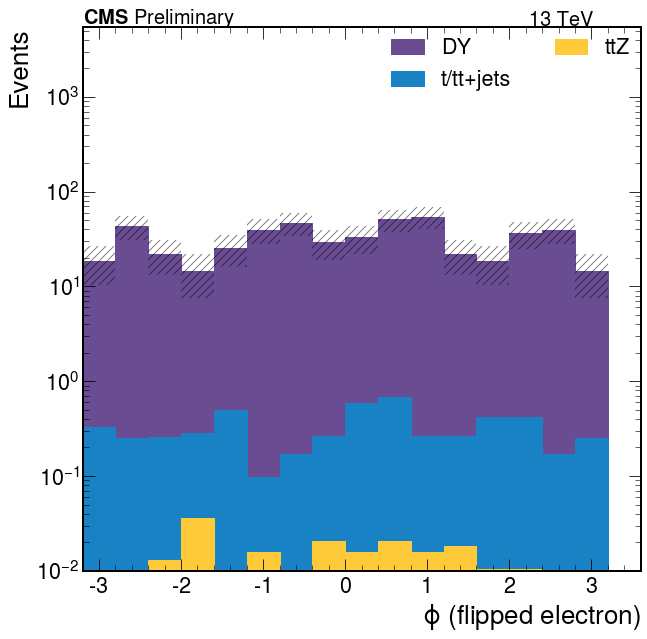

In [37]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'phi',
         bins=phi_bins, log=True, normalize=False, axis_label=r'$\phi\ (flipped\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

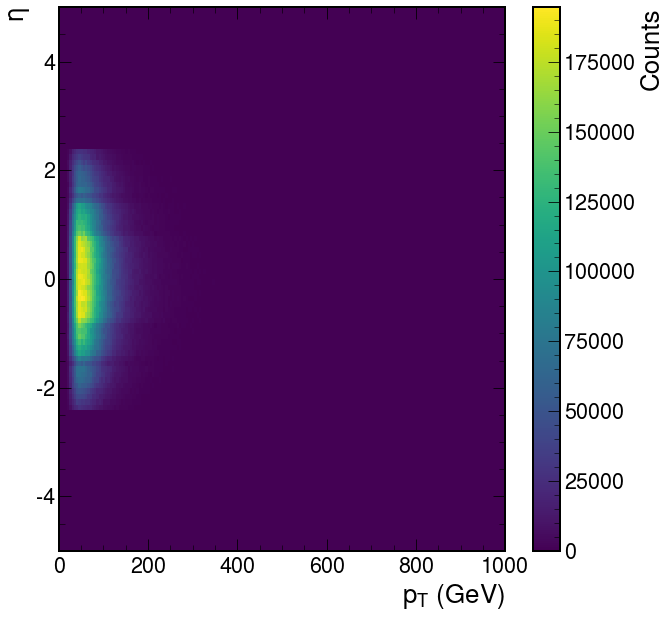

In [39]:
ax = hist.plot2d(
    output['electron'].sum('dataset'),
    xaxis='pt')

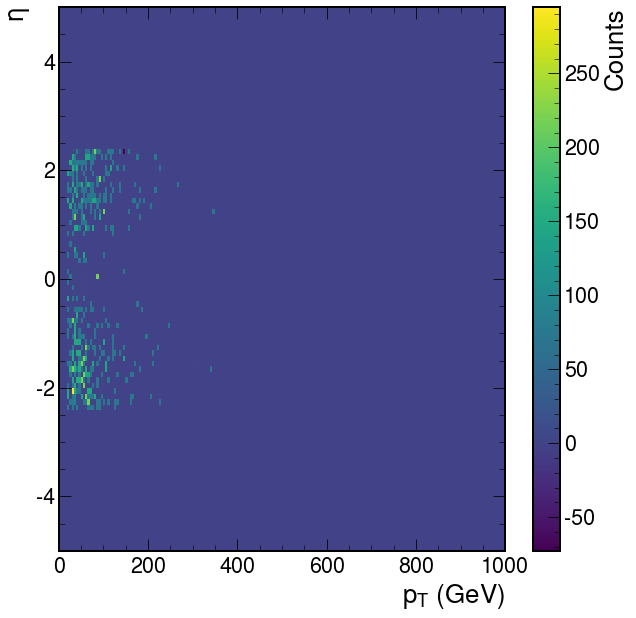

In [40]:
ax = hist.plot2d(
    output['flipped_electron'].sum('dataset'),
    xaxis='pt')

In [25]:
from yahist import Hist1D, Hist2D
import numpy as np

In [41]:
tmp1 = output['flipped_electron'].copy()
tmp1 = tmp1.rebin('eta', eta_bins)
tmp1 = tmp1.rebin('pt', pt_bins)


tmp2 = output['electron'].copy()
tmp2 = tmp2.rebin('eta', eta_bins)
tmp2 = tmp2.rebin('pt', pt_bins)

h1 = Hist2D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),
)


h2 = Hist2D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),
)

#h1 = Hist2D.from_bincounts(
#    output['flipped_electron'].sum('dataset').values()[()].T,
#    (output['flipped_electron'].axis('pt').edges(), output['flipped_electron'].axis('eta').edges()),
#)


#h2 = Hist2D.from_bincounts(
#    output['electron'].sum('dataset').values()[()].T,
#    (output['electron'].axis('pt').edges(), output['electron'].axis('eta').edges()),
#)

In [44]:
h1.divide(h2)

[[  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.01 ± 0.00    0.00 ± 0.00    0.01 ± 0.00    0.02 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00     nan ±  nan    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.11 ± 0.01    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00     nan ±  nan    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00     nan ±  nan
   0.00 ± 0.00    0.04 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.01 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [  nan ±  nan    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.01 ± 0.00    0.02 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00     nan ±  nan    0.00 ± 0.00    0.00 ± 0.00]]

In [42]:
h1

[[ 0.00 ± 0.00   1292.13 ± 35.95   511.71 ± 22.62   1242.67 ± 35.25
  515.43 ± 22.70   147.40 ± 12.14   291.07 ± 17.06    0.51 ± 0.72
  218.09 ± 14.77    0.51 ± 0.72   72.70 ± 8.53   72.70 ± 8.53
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   1443.56 ± 37.99   1974.48 ± 44.44   955.31 ± 30.91
  294.28 ± 17.15   365.53 ± 19.12   71.97 ± 8.48   72.70 ± 8.53
  218.58 ± 14.78   73.73 ± 8.59   74.21 ± 8.61    0.00 ± 0.00
   0.00 ± 0.00     nan ±  nan    0.00 ± 0.00    0.51 ± 0.72
   0.00 ± 0.00   73.21 ± 8.56    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   915.41 ± 30.26   1272.45 ± 35.67   734.04 ± 27.09
  436.74 ± 20.90   293.79 ± 17.14   508.38 ± 22.55   218.09 ± 14.77
   1.02 ± 1.01   73.72 ± 8.59   72.18 ± 8.50   73.21 ± 8.56
   0.00 ± 0.00    0.51 ± 0.72    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   1039.89 ± 32.25   675.07 ± 25.98   293.79 ± 17.14
  220.09 ± 14.84   218.60 ± 14.79   72.70 ± 8.53    0.00 ± 0.00
   0.00 ± 0.00   72.70 ± 8.53    0.00 ± 0.00    0.00 ± 0.00
  72.70 ± 8.53    0.00 ± 0.00     nan ±  nan    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   372.54 ± 19.30   158.49 ± 12.59   74.21 ± 8.61
   0.00 ± 0.00    0.51 ± 0.71    0.51 ± 0.71    0.00 ± 0.00
  71.97 ± 8.48    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   299.58 ± 17.31   371.26 ± 19.27   74.21 ± 8.61
  217.88 ± 14.76   72.70 ± 8.53    0.00 ± 0.00   73.21 ± 8.56
   0.50 ± 0.71    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.51 ± 0.71
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   527.69 ± 22.97   311.58 ± 17.65   365.49 ± 19.12
   2.02 ± 1.42   145.40 ± 12.06   145.40 ± 12.06   71.97 ± 8.48
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.51 ± 0.72    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   1054.40 ± 32.47   903.20 ± 30.05   659.79 ± 25.69
  730.98 ± 27.04   437.73 ± 20.92    0.00 ± 0.00   73.18 ± 8.55
  219.09 ± 14.80   217.37 ± 14.74   73.21 ± 8.56    0.51 ± 0.72
   0.51 ± 0.72    0.00 ± 0.00    1.00 ± 1.00     nan ±  nan
   0.00 ± 0.00   72.70 ± 8.53    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   1011.89 ± 31.81   1009.64 ± 31.77   955.35 ± 30.91
  511.89 ± 22.62   581.86 ± 24.12   220.64 ± 14.85    2.02 ± 1.42
  73.21 ± 8.56   73.21 ± 8.56   72.69 ± 8.53    0.51 ± 0.72
   0.00 ± 0.00   72.70 ± 8.53    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00   785.99 ± 28.04   647.59 ± 25.45   1026.29 ± 32.04
  510.40 ± 22.59   511.16 ± 22.61   293.31 ± 17.13   73.21 ± 8.56
  73.70 ± 8.58    0.00 ± 0.00   72.70 ± 8.53   72.70 ± 8.53
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]]

In [43]:
h2

[[ 0.00 ± 0.00   261830.04 ± 511.69   584027.19 ± 764.22
  442504.35 ± 665.21   270058.53 ± 519.67   150377.11 ± 387.78
  81799.06 ± 286.01   42296.60 ± 205.66   24181.28 ± 155.50
  10177.61 ± 100.88   6147.97 ± 78.41   3372.33 ± 58.07   2196.75 ± 46.87
  1465.66 ± 38.28   223.15 ± 14.94   228.70 ± 15.12   147.94 ± 12.16
  147.43 ± 12.14    2.03 ± 1.42   74.73 ± 8.64]
 [ 0.00 ± 0.00   539794.96 ± 734.71   1288774.70 ± 1135.24
  1068143.94 ± 1033.51   674401.46 ± 821.22   396508.40 ± 629.69
  218795.14 ± 467.76   123721.63 ± 351.74   72040.06 ± 268.40
  40917.49 ± 202.28   23008.43 ± 151.69   13257.47 ± 115.14
  8289.13 ± 91.04   5427.78 ± 73.67   2291.12 ± 47.87   2862.87 ± 53.51
  1541.64 ± 39.26   663.33 ± 25.76   78.82 ± 8.88   296.88 ± 17.23]
 [ 0.00 ± 0.00   966274.59 ± 982.99   2278003.10 ± 1509.31
  1898844.59 ± 1377.99   1244809.08 ± 1115.71   736028.41 ± 857.92
  409798.81 ± 640.16   245703.32 ± 495.68   137155.81 ± 370.35
  83758.79 ± 289.41   50116.01 ± 223.87   26918.90 ± 164.07
  20210.80 ± 142.16   11306.19 ± 106.33   6847.62 ± 82.75
  3975.30 ± 63.05   4322.68 ± 65.75   2213.10 ± 47.04   756.58 ± 27.51
  1475.71 ± 38.42]
 [ 0.00 ± 0.00   1340567.52 ± 1157.83   3219415.85 ± 1794.27
  2741698.26 ± 1655.81   1845343.42 ± 1358.43   1135142.86 ± 1065.43
  663527.34 ± 814.57   395002.52 ± 628.49   228391.91 ± 477.90
  140908.20 ± 375.38   85010.63 ± 291.57   56474.74 ± 237.64
  34989.00 ± 187.05   20529.08 ± 143.28   14643.38 ± 121.01
  11100.52 ± 105.36   6345.80 ± 79.66   4018.32 ± 63.39   2588.91 ± 50.88
  2013.83 ± 44.88]
 [ 0.00 ± 0.00   1440706.64 ± 1200.29   3634423.17 ± 1906.42
  3241318.32 ± 1800.37   2230490.58 ± 1493.48   1405478.49 ± 1185.53
  834008.61 ± 913.24   510692.66 ± 714.63   294714.95 ± 542.88
  185269.59 ± 430.43   114201.60 ± 337.94   69250.37 ± 263.15
  48963.22 ± 221.28   33768.27 ± 183.76   21046.94 ± 145.08
  14011.39 ± 118.37   8164.27 ± 90.36   6739.00 ± 82.09   3719.22 ± 60.99
  3784.44 ± 61.52]
 [ 0.00 ± 0.00   1397519.69 ± 1182.17   3592832.18 ± 1895.48
  3212812.90 ± 1792.43   2227521.31 ± 1492.49   1388401.61 ± 1178.30
  831270.42 ± 911.74   490554.77 ± 700.40   298939.77 ± 546.75
  190178.34 ± 436.09   118451.23 ± 344.17   71749.37 ± 267.86
  48399.66 ± 220.00   31300.97 ± 176.92   20373.80 ± 142.74
  13945.51 ± 118.09   9175.07 ± 95.79   6284.93 ± 79.28   4735.68 ± 68.82
  3209.17 ± 56.65]
 [ 0.00 ± 0.00   1315786.51 ± 1147.08   3216649.52 ± 1793.50
  2730590.93 ± 1652.45   1818144.71 ± 1348.39   1101816.57 ± 1049.67
  662841.31 ± 814.15   382604.26 ± 618.55   227570.70 ± 477.04
  139223.85 ± 373.13   84465.12 ± 290.63   56154.95 ± 236.97
  31426.09 ± 177.27   21817.88 ± 147.71   13396.84 ± 115.74
  11022.74 ± 104.99   6798.31 ± 82.45   3637.19 ± 60.31   2815.87 ± 53.06
  1791.20 ± 42.32]
 [ 0.00 ± 0.00   928921.91 ± 963.81   2168774.14 ± 1472.68
  1805001.59 ± 1343.50   1183994.19 ± 1088.11   691264.81 ± 831.42
  401290.55 ± 633.47   227280.87 ± 476.74   127313.98 ± 356.81
  75082.98 ± 274.01   46816.73 ± 216.37   29542.75 ± 171.88
  18762.82 ± 136.98   12176.07 ± 110.35   6040.25 ± 77.72
  5295.85 ± 72.77   2381.51 ± 48.80   1846.80 ± 42.97   1692.74 ± 41.14
  888.94 ± 29.82]
 [ 0.00 ± 0.00   485691.97 ± 696.92   1240354.41 ± 1113.71
  1033608.19 ± 1016.67   662277.13 ± 813.80   393535.30 ± 627.32
  214003.23 ± 462.60   123572.45 ± 351.53   59945.02 ± 244.84
  39185.38 ± 197.95   22688.88 ± 150.63   13246.81 ± 115.09
  8426.39 ± 91.80   4992.00 ± 70.65   3229.16 ± 56.83   2352.12 ± 48.50
  1471.48 ± 38.36   735.13 ± 27.11   367.10 ± 19.16   222.67 ± 14.92]
 [ 0.00 ± 0.00   281952.23 ± 530.99   596654.46 ± 772.43
  468326.02 ± 684.34   282234.33 ± 531.26   150484.71 ± 387.92
  78073.57 ± 279.42   42407.39 ± 205.93   22448.11 ± 149.83
  11975.75 ± 109.43   7524.09 ± 86.74   2930.61 ± 54.14   2349.68 ± 48.47
  519.50 ± 22.79   518.49 ± 22.77   152.44 ± 12.35   74.73 ± 8.64
   0.00 ± 0.00   146.94 ± 12.12   73.70 ± 8.58]]